# Bike Sharing: Predicción de Demanda Horaria

In [ ]:
explicacion

|Atributo| Descripción |
|--------|-------------|
|_datetime_| algo|
|_season_ | algo|
|_holiday_| otro algo|
|_workingday_| bla|
|_weather_| bla|
|_temp_| caca|
|_atemp_|caca|
|_humidity_|blabla|
|_windspeed_|caca|
|_casual_|casc|
|_registered_|blasd|
|_count_| demanda|  

hourly date + timestamp
1 = spring, 2 = summer, 3 = fall, 4 = winter
whether the day is considered a holiday
whether the day is neither a weekend nor holiday
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temperature in Celsius
“feels like” temperature in Celsius
relative humidity
wind speed
number of non-registered user rentals initiated
number of registered user rentals initiated
number of total rentals

## A)

In [1]:
import pandas as pd
import numpy as np
dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
df = df.drop('Unnamed: 0',axis=1)

print('\nSummary - dataframe completo:\n')
print(df.describe())
#print df
print "Dimensiones de training set: "
print dftrain.shape
print "Dimensiones de validation set: "
print dfval.shape
print "Dimensiones de test set: "
print dftest.shape

print len(df)
#procesamiento
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])


Summary - dataframe completo:

             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.2

[13773, 60141, 43002, 53708, 53708, 53708] [27250, 98354, 81833, 96599, 96599, 96599] [33947, 104681, 89197, 100973, 100973, 100973] [27305, 99762, 78460, 93241, 93241, 93241]


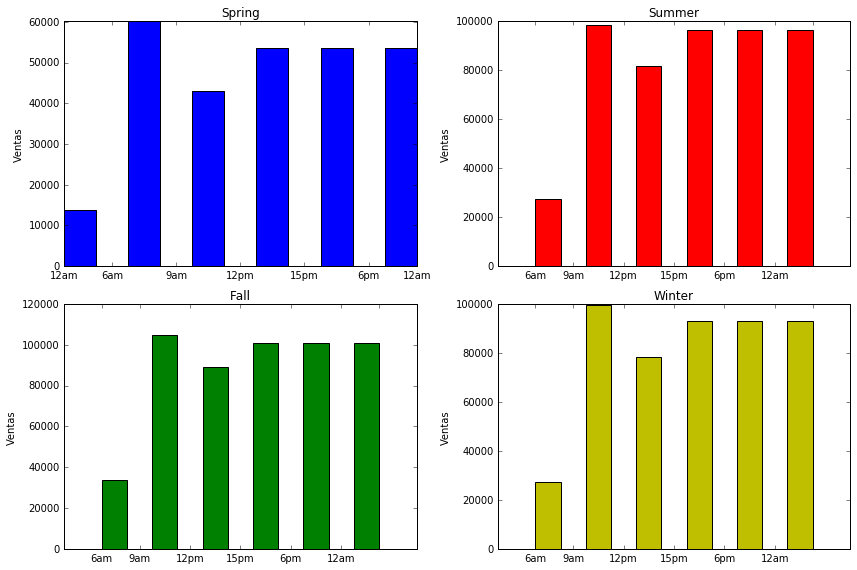

In [2]:
import matplotlib.pyplot as plt

spring_rows1 = df[ (df['season'] == 1) & (df['hour'] <= 6)]
spring_rows2 = df[ (df['season'] == 1) & (df['hour'] > 6) & (df['hour'] <= 9)]
spring_rows3 = df[ (df['season'] == 1) & (df['hour'] > 9) & (df['hour'] <= 12)]
spring_rows4 = df[ (df['season'] == 1) & (df['hour'] > 12) & (df['hour'] <= 15)]
spring_rows5 = df[ (df['season'] == 1) & (df['hour'] > 15) & (df['hour'] <= 18)]
spring_rows6 = df[ (df['season'] == 1) & (df['hour'] > 18) & (df['hour'] <= 24)]

spring_vals = [sum(spring_rows1['count']),sum(spring_rows2['count']),sum(spring_rows3['count']),sum(spring_rows4['count'])
              ,sum(spring_rows4['count']),sum(spring_rows4['count'])]

summer_rows1 = df[ (df['season'] == 2) & (df['hour'] <= 6)]
summer_rows2 = df[ (df['season'] == 2) & (df['hour'] > 6) & (df['hour'] <= 9)]
summer_rows3 = df[ (df['season'] == 2) & (df['hour'] > 9) & (df['hour'] <= 12)]
summer_rows4 = df[ (df['season'] == 2) & (df['hour'] > 12) & (df['hour'] <= 15)]
summer_rows5 = df[ (df['season'] == 2) & (df['hour'] > 15) & (df['hour'] <= 18)]
summer_rows6 = df[ (df['season'] == 2) & (df['hour'] > 18) & (df['hour'] <= 24)]

summer_vals = [sum(summer_rows1['count']),sum(summer_rows2['count']),sum(summer_rows3['count']),sum(summer_rows4['count'])
              ,sum(summer_rows4['count']),sum(summer_rows4['count'])]

fall_rows1 = df[ (df['season'] == 3) & (df['hour'] <= 6)]
fall_rows2 = df[ (df['season'] == 3) & (df['hour'] > 6) & (df['hour'] <= 9)]
fall_rows3 = df[ (df['season'] == 3) & (df['hour'] > 9) & (df['hour'] <= 12)]
fall_rows4 = df[ (df['season'] == 3) & (df['hour'] > 12) & (df['hour'] <= 15)]
fall_rows5 = df[ (df['season'] == 3) & (df['hour'] > 15) & (df['hour'] <= 18)]
fall_rows6 = df[ (df['season'] == 3) & (df['hour'] > 18) & (df['hour'] <= 24)]

fall_vals = [sum(fall_rows1['count']),sum(fall_rows2['count']),sum(fall_rows3['count']),sum(fall_rows4['count'])
              ,sum(fall_rows4['count']),sum(fall_rows4['count'])]

winter_rows1 = df[ (df['season'] == 4) & (df['hour'] <= 6)]
winter_rows2 = df[ (df['season'] == 4) & (df['hour'] > 6) & (df['hour'] <= 9)]
winter_rows3 = df[ (df['season'] == 4) & (df['hour'] > 9) & (df['hour'] <= 12)]
winter_rows4 = df[ (df['season'] == 4) & (df['hour'] > 12) & (df['hour'] <= 15)]
winter_rows5 = df[ (df['season'] == 4) & (df['hour'] > 15) & (df['hour'] <= 18)]
winter_rows6 = df[ (df['season'] == 4) & (df['hour'] > 18) & (df['hour'] <= 24)]

winter_vals = [sum(winter_rows1['count']),sum(winter_rows2['count']),sum(winter_rows3['count']),sum(winter_rows4['count'])
              ,sum(winter_rows4['count']),sum(winter_rows4['count'])]


print spring_vals, summer_vals,fall_vals,winter_vals

# Construir histograma -------------------------------------------

#PARA COMPARAR LAS EPOCAS DEL AÑO
f, axarr = plt.subplots(2, 2, figsize=(12,8) )
axarr[0, 0].bar(np.arange(0,6,1), spring_vals, width  = 0.5, align = "center", color = 'b')
axarr[0, 0].set_title('Spring')
axarr[0, 0].set_xticks([-0.25,0.5,1.5,2.5,3.5,4.5,5.25])
axarr[0, 0].set_xticklabels(('12am','6am','9am','12pm','15pm','6pm','12am'))
axarr[0, 0].set_ylabel('Ventas')
axarr[0, 0].axis('tight')

axarr[0, 1].bar(np.arange(0,6,1), summer_vals, width  = 0.5, align = "center", color = 'r')
axarr[0, 1].set_title('Summer')
axarr[0, 1].set_xticks([-0.25,0.5,1.5,2.5,3.5,4.5,5.25])
axarr[0, 1].set_xticklabels(('6am','9am','12pm','15pm','6pm','12am'))
axarr[0, 1].set_ylabel('Ventas')

axarr[1, 0].bar(np.arange(0,6,1), fall_vals, width  = 0.5, align = "center", color = 'g')
axarr[1, 0].set_title('Fall')
axarr[1, 0].set_xticks([-0.25,0.5,1.5,2.5,3.5,4.5,5.25])
axarr[1, 0].set_xticklabels(('6am','9am','12pm','15pm','6pm','12am'))
axarr[1, 0].set_ylabel('Ventas')

axarr[1, 1].bar(np.arange(0,6,1), winter_vals, width  = 0.5, align = "center", color = 'y')
axarr[1, 1].set_title('Winter')
axarr[1, 1].set_xticks([-0.25,0.5,1.5,2.5,3.5,4.5,5.25])
axarr[1, 1].set_xticklabels(('6am','9am','12pm','15pm','6pm','12am'))
axarr[1, 1].set_ylabel('Ventas')


f.tight_layout() #separar los subplot
plt.show()


## B)

SCORE TEST=0.703388
KAGG EVAL TRAIN =0.028516
KAGG EVAL VAL =0.554511
KAGG EVAL TEST =0.574239


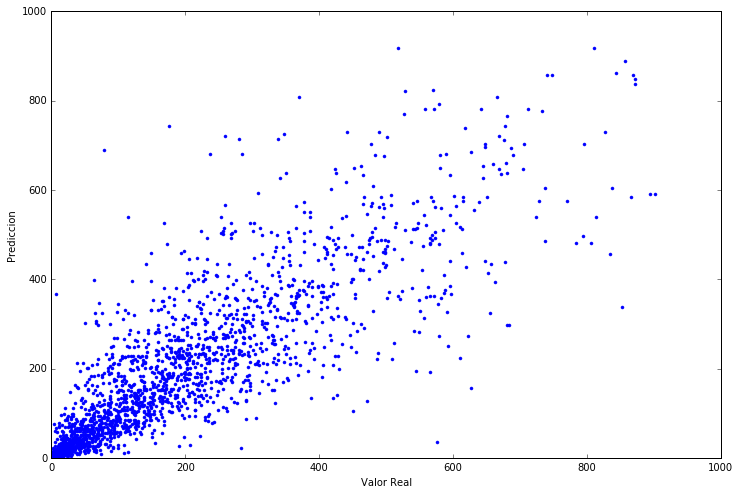

In [3]:
from sklearn.tree import DecisionTreeRegressor as Tree
import matplotlib.pyplot as plt

def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))


Xdf=df.ix[:,['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour']]
Ydf=df.ix[:,'count']

X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values

Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

#Modelo
model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print "SCORE TEST=%f"%score_test

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)

print "KAGG EVAL TRAIN =%f"%kagg_train
print "KAGG EVAL VAL =%f"%kagg_val
print "KAGG EVAL TEST =%f"%kagg_test

plt.figure(figsize=(12,8))
plt.plot(Y_test,Y_pred_test,'.')
plt.xlabel('Valor Real')
plt.ylabel('Prediccion')
plt.show()

## C)

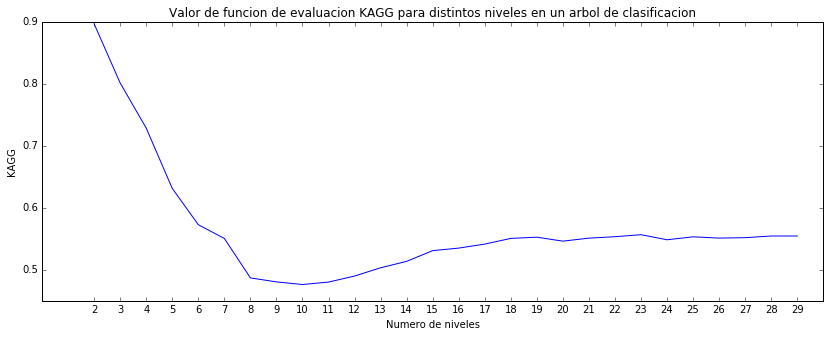

In [7]:
kaggs = []
N_ts = np.arange(2,30)
for n_t in N_ts:
    model = Tree(random_state=0,max_depth=n_t)
    model.fit(X_train,Y_train)

    Y_pred_val = model.predict(X_val)
    kagg_val = eval_bikemodel(Y_pred_val,Y_val)
    kaggs.append(kagg_val)

plt.figure(figsize=(14,5))    
plt.plot(N_ts,kaggs)
plt.xticks(N_ts)
plt.xlabel('Numero de niveles')
plt.ylabel('KAGG')
plt.title('Valor de funcion de evaluacion KAGG para distintos niveles en un arbol de clasificacion')
plt.show()

In [8]:
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)

Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

KAGG EVAL VAL =0.476274


## D)

In [9]:
#procesamiento de fecha(datetime-timestamp) a numeros
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek#0:lunes,6:domingo
df['cday'] = pd.to_numeric(df['cday'])

df['year'] = pd.to_datetime(df['datetime']).dt.year#0:lunes,6:domingo
df['year'] = pd.to_numeric(df['year'])

df['month'] = pd.to_datetime(df['datetime']).dt.month#0:lunes,6:domingo
df['month'] = pd.to_numeric(df['month'])


once = df[ (df['year'] == 2011)]
print sum(once['count'])
donce = df[ (df['year'] == 2012)]
print sum(donce['count'])

df2 = df.drop('datetime', axis=1)

781979
1303497


In [10]:
def fss(x, y, xval,yval, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)+1
    names_x = np.array(names_x)
    remaining = range(0, p+1)
    selected = []
    current_score = 0.0
    best_new_score = 0.0
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            model = Tree()
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            x_val = xval[:,indexes]
            
            predictions_val = model.fit(x_train, y).predict(x_val)
            kagg_val = eval_bikemodel(predictions_val,yval) #en base al evaluador kagg
            
            score_candidates.append((kagg_val, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop() #el de menor error es el mejor candidato
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print "selected = %s ..."%names_x[best_candidate]
    return selected

names_features = ['season','holiday','workingday','weather','temp','atemp',
    'humidity','windspeed','hour','cday','month','year']
Xdf=df2.ix[:,names_features]
Ydf=df2.ix[:,'count'] 

X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
        
new_names_features = fss(X_train,Y_train,X_val,Y_val,names_features)[:8]
new_names_features = np.array(names_features)[new_names_features]
print "se eliminaron"
x = set(names_features)
y = x - set(new_names_features)
print y

selected = hour ...
selected = cday ...
selected = season ...
selected = year ...
selected = workingday ...
selected = holiday ...
selected = weather ...
selected = atemp ...
selected = month ...
selected = humidity ...
selected = temp ...
selected = windspeed ...
se eliminaron
set(['windspeed', 'humidity', 'temp', 'month'])


|nombre|caracteristicas|normalizado|transformacion(y)|
|------|---------------|-----------|--------------|
|old|season, holiday, workingday, weather, temp, atemp, humidity,windspeed, hour|  X | X|
|all|old + **cday**, **month** | X | X |
|extract|season, holiday, workingday, weather, atemp, hour, cday | X | X|

In [98]:
#print df2
print "---------------------------------------------"
names_features = ['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour','cday','month','year']

df2 = df2.ix[:,names_features+['count']]

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
def representacion(df, features,scaler,vector=False):
    if features == "all":
        names_features = ['season','holiday','workingday','weather','temp','atemp',
                            'humidity','windspeed','hour','cday','month','year']
    elif features == "old":
        names_features = ['season','holiday','workingday','weather','temp','atemp',
                        'humidity','windspeed','hour']
    elif features == "extract":
        names_features = ['season','holiday','workingday','weather','atemp','hour','cday','year']


    #se procesan las caract
    Xdf=df.ix[:,names_features]
    
    if vector: #para representacion vectorial de variables categoricas
        all_categorical_features = ['season','weather','hour','cday','month']
        x = set(all_categorical_features)
        categorical_features = x.intersection(names_features)

        Xdf = pd.get_dummies(Xdf,columns=categorical_features) #categorizar las caract
    
    #se crean las matrices
    Ydf=df.ix[:,'count'] #no se normaliza
    X_train = Xdf[0:ntrain].values
    X_val = Xdf[ntrain:nval].values
    X_test = Xdf[nval:].values
    Y_train = Ydf[0:ntrain].values
    Y_val = Ydf[ntrain:nval].values
    Y_test = Ydf[nval:].values
        
    #se escala
    if scaler == "standar":
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_val = scaler.fit_transform(X_val)
        
        return X_train,Y_train,X_val,Y_val,X_test,Y_test
            
    elif scaler == "normal":
        return X_train, Y_train, X_val, Y_val,X_test,Y_test
    return 0
   
print "representacion normal de las viejas caracteristicas"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"old","normal")
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "representacion con escalamiento de las viejas caracteristicas"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"old","standar")
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val
print "---------------------------------------------"

print "representacion normal de todas las caracteristicas"
X_train,Y_train,X_val,Y_val, X_test,Y_test = representacion(df2,"all","normal")
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val
print "---------------------------------------------"

print "representacion con escalamiento de todas las caracteristicas"
X_train,Y_train,X_val,Y_val, X_test,Y_test = representacion(df2,"all","standar")
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "---------------------------------------------"
print "representacion con extraccion de caracteristicas no normalizadas"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","normal")
model = Tree(random_state=0,max_depth=10) #esto
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "---------------------------------------------"
print "representacion con extraccion de caracteristicas normalizadas"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar")
model = Tree(random_state=0,max_depth=10) #esto
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "---------------------------------------------"
print "representacion con extracion de caracteristicas normalizadas y transformar la respuesta"
X_train,Y_train,X_val,Y_val, X_test,Y_test = representacion(df2,"extract","standar")

#transforma la respuesta (Target)
Y_train = np.log(Y_train+1)
Y_val = np.log(Y_val+1)
        
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train) #ajusta el modelo con target normalizado
Y_pred_val = model.predict(X_val)


#volver a la variable original
Y_val = np.exp(Y_val)-1
Y_pred_val = np.exp(Y_pred_val)-1

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

---------------------------------------------
representacion normal de las viejas caracteristicas
KAGG EVAL VAL =0.476274
representacion con escalamiento de las viejas caracteristicas
KAGG EVAL VAL =0.477858
---------------------------------------------
representacion normal de todas las caracteristicas
KAGG EVAL VAL =0.406954
---------------------------------------------
representacion con escalamiento de todas las caracteristicas
KAGG EVAL VAL =0.407576
---------------------------------------------
representacion con extraccion de caracteristicas no normalizadas
KAGG EVAL VAL =0.395105
---------------------------------------------
representacion con extraccion de caracteristicas normalizadas
KAGG EVAL VAL =0.394858
---------------------------------------------
representacion con extracion de caracteristicas normalizadas y transformar la respuesta
KAGG EVAL VAL =0.418274


## E)

In [86]:
X_train,Y_train,X_val,Y_val = representacion(df2,"extract","standar",vector=True)
print "representacion con extraccion de caracteristicas normalizadas y transformar el Y(target)"


#transformar el Y
Y_train = np.log(Y_train+1)
Y_val = np.log(Y_val+1)
        
# Se ajusta a modelo SVR
from sklearn.svm import SVR
model = SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
#Y_pred_test = model.predict(X_test)

#volver a la variable original
Y_train = np.exp(Y_train)-1
Y_pred_train = np.exp(Y_pred_train)
Y_val = np.exp(Y_val) -1
Y_pred_val = np.exp(Y_pred_val) -1


kagg_val = eval_bikemodel(Y_pred_train,Y_train)
print "KAGG EVAL TRAIN =%f"%kagg_val
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

representacion con extraccion de caracteristicas normalizadas y transformar el Y(target)
KAGG EVAL TRAIN =0.276680
KAGG EVAL VAL =0.316920


## F) SVR (regresion) no lineal - variacion de parametros

In [131]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar",vector=True)
print "representacion con extraccion de caracteristicas normalizadas y transformar el Y(target)"

# Se ajusta a modelo SVR
from sklearn.svm import SVR
Cs = [0.001,0.01,0.1,1,10,100]
es = [0.001,0.01,0.1,1,10]
info = []
for c in Cs:
    subinfo=[]
    for e in es:
        #transformar el Y
        Y_train = np.log(Y_train+1)
        Y_val = np.log(Y_val+1)

        model = SVR(kernel='rbf', C=c, epsilon=e)
        model.fit(X_train,Y_train)
        #Y_pred_train = model.predict(X_train)
        Y_pred_val = model.predict(X_val)
        #Y_pred_test = model.predict(X_test)

        #volver a la variable original
        Y_train = np.exp(Y_train) -1
        Y_val = np.exp(Y_val) -1
        Y_pred_val = np.exp(Y_pred_val) -1

        #kagg_train = eval_bikemodel(Y_pred_train,Y_train)
        kagg_val = eval_bikemodel(Y_pred_val,Y_val)
        subinfo.append(kagg_val)
        #print "KAGG EVAL TRAIN =%f"%kagg_train
        #print "KAGG EVAL VAL =%f"%kagg_val
    info.append(subinfo)
print info

representacion con extraccion de caracteristicas normalizadas y transformar el Y(target)
[[1.3888119623398345, 1.3892056452556643, 1.3894093630912228, 1.3736750814760479, 1.6644681370370946], [0.96625289929329283, 0.96658831302758874, 0.9662010345803419, 1.0795615696535581, 1.6644681370370946], [0.38095961177310389, 0.38112685393430695, 0.38446638098908703, 0.73936475152902703, 1.6644681370370946], [0.32069390595809305, 0.32016431628388348, 0.31691987316282605, 0.6489748421696373, 1.6644681370370946], [0.34409729645151665, 0.34299164531706072, 0.33325336017241186, 0.62821522513619943, 1.6644681370370946], [0.37142676718003315, 0.36893377390151777, 0.35160101897108875, 0.62206343627790728, 1.6644681370370946]]


In [150]:
fila1 = ['C/Epsilon']+es
filas = [[Cs[i]]+info[i] for i in range(len(info))]
table = [fila1]+filas
from tabulate import tabulate
print tabulate(table,   tablefmt="rst")

=========  ========  ========  ========  ========  ========
C/Epsilon  0.001     0.01      0.1       1         10
0.001      1.38881   1.38921   1.38941   1.37368    1.66447
0.01       0.966253  0.966588  0.966201  1.07956    1.66447
0.1        0.38096   0.381127  0.384466  0.739365   1.66447
1          0.320694  0.320164  0.31692   0.648975   1.66447
10         0.344097  0.342992  0.333253  0.628215   1.66447
100        0.371427  0.368934  0.351601  0.622063   1.66447
=========  ========  ========  ========  ========  ========


## G) Cross-validation

In [156]:
from sklearn import cross_validation

def cross_validation_fun(X_train,Y_train,model):
    k_fold = cross_validation.KFold(len(X_train)-2,10)
    score_cv = 0
    for k, (train, val) in enumerate(k_fold):
        #model = ) #SVR(C=1,epsilon=0.1)
        model.fit(X_train[train], Y_train[train])
        Ypred_val = model.predict(X_train[val])
        Ytrue_val = Y_train[val]
        score_fold = eval_bikemodel(Ypred_val,Ytrue_val)
        score_cv += score_fold
    score_cv = score_cv / 10
    return score_cv

# score_cv SVM:
# score_cv Tree:

print "*Árbol de clasificación" #mejor representacion para el arbol
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","normal")

#añadir X_val a X_train
print X_val.shape, X_train.shape
print Y_val.shape, Y_train.shape

newX_train = np.concatenate((X_train,X_val))
newY_train = np.concatenate((Y_train,Y_val))
print newX_train.shape
print newY_train.shape
print cross_validation_fun(newX_train,newY_train, Tree(random_state=0,max_depth=10))

*Árbol de clasificación
(2177, 8) (6562, 8)
(2177,) (6562,)
(8739, 8)
(8739,)
0.422384571998


## H)

In [161]:
Ydf=df.ix[:,'count'] #demanda total

def do_ensambler(model1,model2):
    # ------------------ Demanda Registrada ---------------------------
    Ydf=df.ix[:,'registered']     
    
    Yreg_train = Ydf[0:ntrain].values
    Yreg_val = Ydf[ntrain:nval].values
    Yreg_test = Ydf[nval:].values

    if model1 == "arbol":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar")
        model = Tree(random_state=0,max_depth=10)
        
    elif model1 == "svm":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar",vector=True)
        #transformar el Y de entrenamiento
        Yreg_train = np.log(Yreg_train+1)
        
        model = SVR(kernel='rbf', C=1, epsilon=0.1)
        
    model.fit(X_train,Yreg_train)
    Yreg_pred_val = model.predict(X_val)
    
    if model1=="svm": #volver a variable original
        Yreg_pred_val = np.exp(Yreg_pred_val)-1

        
    # ------------------ Demanda Casual ---------------------------
    Ydf=df.ix[:,'casual'] #demanda casual
    
    Ycas_train = Ydf[0:ntrain].values
    Ycas_val = Ydf[ntrain:nval].values
    Ycas_test = Ydf[nval:].values
    
    if model2 == "arbol":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar")
        model = Tree(random_state=0,max_depth=10)
        
    elif model2 == "svm":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar",vector=True)
        #transformar Y entrenamiento
        Ycas_train = np.log(Ycas_train+1)
        
        model = SVR(kernel = 'rbf', C=1,epsilon=0.1)
    
    model.fit(X_train,Ycas_train)
    Ycas_pred_val = model.predict(X_val)
    
    if model2 == "svm": #volver a variable original
        Ycas_pred_val = np.exp(Ycas_pred_val)-1

    return Yreg_pred_val+Ycas_pred_val

print "**la demanda es definida registered-casual**"

print "Para la combinacion SVM-SVM"
Y_pred_val = do_ensambler("svm","svm")

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "Para la combinacion SVM-TREE"
Y_pred_val = do_ensambler("svm","arbol")

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "Para la combinacion TREE-SVM"
Y_pred_val = do_ensambler("arbol","svm")

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "Para la combinacion TREE-TREE"
Y_pred_val = do_ensambler("arbol","arbol")

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

**la demanda es definida registered-casual**
Para la combinacion SVM-SVM
KAGG EVAL VAL =0.315239
Para la combinacion SVM-TREE
KAGG EVAL VAL =0.311762
Para la combinacion TREE-SVM
KAGG EVAL VAL =0.362839
Para la combinacion TREE-TREE
KAGG EVAL VAL =0.366786


## I)

In [165]:
from sklearn.ensemble import RandomForestRegressor

X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar")
newX_train = np.concatenate((X_train,X_val))
newY_train = np.concatenate((Y_train,Y_val))

N = np.arange(1,50)
info1 = []
mejor = 1
mejor_numero = 0
for n_trees in N:
    model = RandomForestRegressor(n_estimators=n_trees,max_depth=10,random_state=0)
    model.fit(newX_train,newY_train)
    
    Y_pred_train = model.predict(newX_train)
    Y_pred_test = model.predict(X_test)
    
    val = cross_validation_fun(newX_train,newY_train,model)
    if val <mejor:
        mejor = kagg_val
        mejor_numero = n_trees
    
    #para grafico de mas abajo
    kagg_train = eval_bikemodel(Y_pred_train,Y_train)
    kagg_test = eval_bikemodel(Y_pred_test,Y_test)
        
    info1.append([kagg_train,kagg_test])

print "NUMBER OF TREES = %d"%mejor_numero
print "BEST KAGG EVAL VAL =%f"%mejor

N = np.arange(1,50)
info2 = []
mejor = 1
mejor_niveles = 0
for level in N:
    model = RandomForestRegressor(n_estimators=5,max_depth=level,random_state=0)
    model.fit(newX_train,newY_train)

    Y_pred_train = model.predict(newX_train)
    Y_pred_test = model.predict(X_test)
    
    val = cross_validation_fun(newX_train,newY_train,model)
    if val <mejor:
        mejor = kagg_val
        mejor_niveles = level

    kagg_train = eval_bikemodel(Y_pred_train,Y_train)
    kagg_test = eval_bikemodel(Y_pred_test,Y_test)
    
    info2.append([kagg_train,kagg_test])

print "DEEPTH = %d"%mejor_niveles
print "BEST KAGG EVAL VAL =%f"%mejor

ValueError: operands could not be broadcast together with shapes (8739,) (6562,) 

In [166]:
error_train1 = [ i[0] for i in info1]
error_val1 = [i[1] for i in info1]
error_test1 = [ i[2] for i in info1]
error_train2 = [ i[0] for i in info2]
error_val2 = [i[1] for i in info2]
error_test2 = [ i[2] for i in info2]

import matplotlib.pyplot as plt
f, axarr = plt.subplots(1, 2, figsize=(15,5))
axarr[0].plot(N,error_train1, label = "Training set")
axarr[0].plot(N,error_val1, label = "Validation set")
axarr[0].plot(N,error_test1, label = "Test set")
#axarr[0].set_xticks(N)
axarr[0].set_xlabel('Numero de maquinas de aprendizaje')
axarr[0].set_ylabel('Error')
axarr[0].set_title('Error sobre RandomForest de profundidad 10')
#axarr[0].set_ylim(0,0.5)
axarr[0].legend(loc="upper right")

axarr[1].plot(N,error_train2, label = "Training set")
axarr[1].plot(N,error_val2, label = "Validation set")
axarr[1].plot(N,error_train2, label = "Test set")
#axarr[1].set_xticks(N)
axarr[1].set_xlabel('Numero de niveles')
axarr[1].set_ylabel('Error')
axarr[1].set_title('Error sobre RandomForest con 45 maquinas de aprendizaje')
axarr[1].legend(loc="upper right")
plt.show()

ValueError: x and y must have same first dimension